# Tensorflow implementation

[Paper](https://arxiv.org/pdf/2010.11929v2.pdf) : An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale

**Import dependencies**

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 13.3 MB/s 


In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


**Load CIFAR10 dataset**

In [67]:
num_classes = 10
input_shape = (32, 32, 3)
drop_rate=0.2

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


## Custom Layers

**Layer to extract patches from input image**



In [68]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
      super(Patches, self).__init__()
      self.patch_size = patch_size
      self.num_patches = num_patches

    def call(self, images):
      batch_size = tf.shape(images)[0]
      patches = tf.image.extract_patches(
          images=images,
          sizes=[1, self.patch_size, self.patch_size, 1],
          strides=[1, self.patch_size, self.patch_size, 1],
          rates=[1, 1, 1, 1],
          padding="VALID",
      )
      patch_dims = patches.shape[-1]
      patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
      return patches


**Positional Encoding for patches**

In [69]:
class PositionalEncoding(layers.Layer):
  def __init__(self, num_patches, embedding_dim):
    super(PositionalEncoding, self).__init__()
    self.num_patches = num_patches
    self.embedding_dim = embedding_dim  # Number of hidden units.
    self.positions = tf.range(start=0, limit=self.num_patches, delta=1)
    self.emb = layers.Embedding(input_dim=self.num_patches, output_dim=self.embedding_dim)

  def call(self, x):
    position_embedding = self.emb(self.positions)
    x = x + position_embedding
    return x

**The transformer block**

In [70]:
class Transformer(layers.Layer):
  def __init__(self, embedding_dim):
    super(Transformer, self).__init__()
    self.hidden_units=[embedding_dim, embedding_dim]
    self.dropout_rate=drop_rate
    self.norm1 = layers.LayerNormalization(epsilon=1e-5)
    self.norm2 = layers.LayerNormalization(epsilon=1e-5)
    self.attention = layers.MultiHeadAttention(num_heads=2, key_dim=128, dropout=self.dropout_rate)
    l = []
    for units in self.hidden_units:
      l.append(layers.Dense(units, activation=tf.nn.gelu))
      l.append(layers.Dropout(self.dropout_rate))
    self.mlp = keras.models.Sequential(l)

  def call(self, x):
    x = self.norm1(x)
    attention_output = self.attention(x, x)
    x1 = x + attention_output

    x = self.norm2(x1)
    x = self.mlp(x)
    return x + x1

###Vision Transformer Model
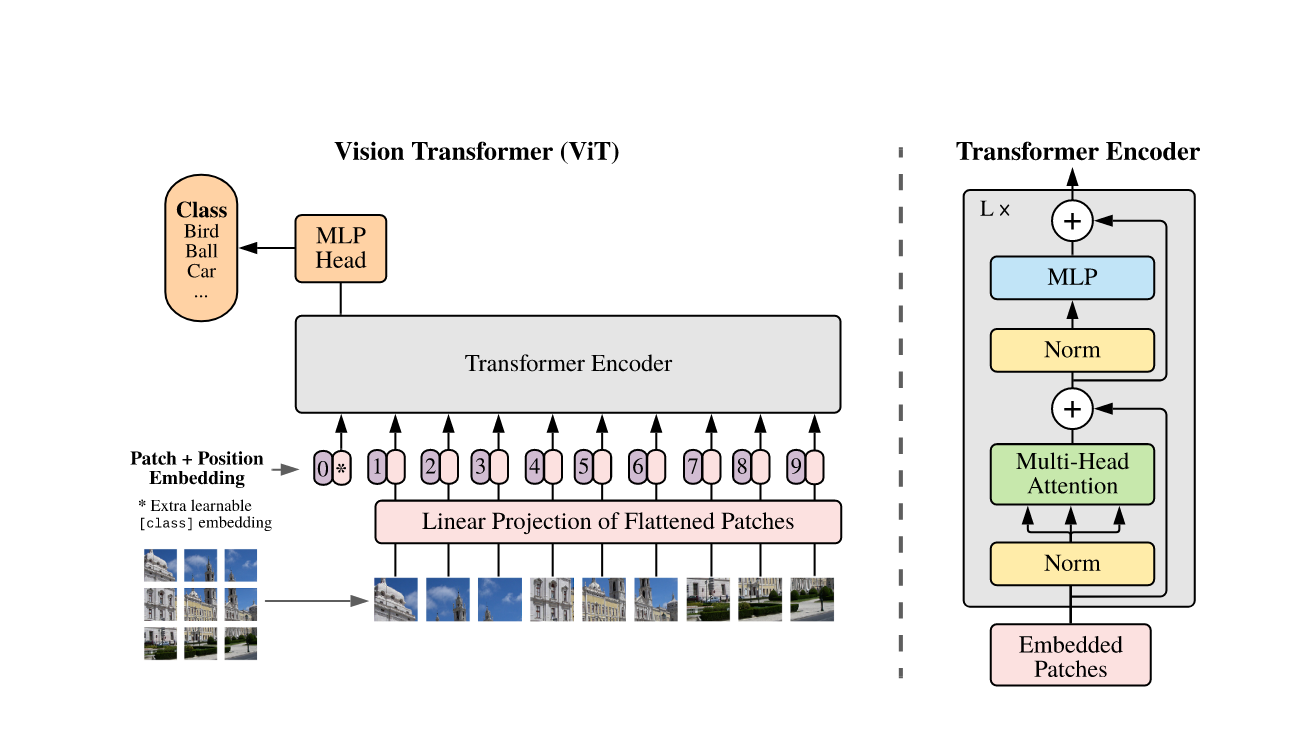

In [71]:
class ViT(keras.models.Model):
  def __init__(self, image_size=32, patch_size=8):
    super(ViT, self).__init__()
    self.num_patches = (image_size // patch_size) ** 2
    self.embedding_dim = 256
    self.blocks=2

    self.data_augmentation = keras.Sequential([layers.Rescaling(scale=1.0 / 255),layers.RandomCrop(image_size, image_size),layers.RandomFlip("horizontal"),],name="data_augmentation",)
    self.encoder = keras.models.Sequential([
                                            Patches(patch_size, self.num_patches),
                                            layers.Dense(self.embedding_dim),
                                            PositionalEncoding(self.num_patches, self.embedding_dim)], name="encoder")

    self.transformers = keras.models.Sequential([Transformer(self.embedding_dim) for i in range(self.blocks)], name="transformers")

    self.head = keras.models.Sequential([layers.GlobalAveragePooling1D(),
                                          layers.Dropout(rate=drop_rate),
                                          layers.Dense(num_classes)], name="classifier")
    

  def call(self, x):
    x = self.data_augmentation(x)
    encodings = self.encoder(x)
    features = self.transformers(encodings)
    logits = self.head(features)
    return logits

**Build Model and print summary**

In [72]:
model = ViT(patch_size=8)
model.build((1, 32, 32, 3))
model.summary()

Model: "vi_t_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (1, 32, 32, 3)           0         
 al)                                                             
                                                                 
 encoder (Sequential)        (1, 16, 256)              53504     
                                                                 
 transformers (Sequential)   (1, 16, 256)              791552    
                                                                 
 classifier (Sequential)     (1, 10)                   2570      
                                                                 
Total params: 847,626
Trainable params: 847,626
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [75]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=30,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


history = run_experiment(model)


Epoch 1/30
352/352 [==============================] - 31s 51ms/step - loss: 2.0980 - accuracy: 0.2626 - top-5-accuracy: 0.7813 - val_loss: 1.8578 - val_accuracy: 0.3382 - val_top-5-accuracy: 0.8756
Epoch 2/30
352/352 [==============================] - 17s 48ms/step - loss: 1.7961 - accuracy: 0.3937 - top-5-accuracy: 0.8830 - val_loss: 1.6875 - val_accuracy: 0.4460 - val_top-5-accuracy: 0.9094
Epoch 3/30
352/352 [==============================] - 17s 48ms/step - loss: 1.6835 - accuracy: 0.4528 - top-5-accuracy: 0.9104 - val_loss: 1.6312 - val_accuracy: 0.4742 - val_top-5-accuracy: 0.9200
Epoch 4/30
352/352 [==============================] - 17s 49ms/step - loss: 1.6220 - accuracy: 0.4872 - top-5-accuracy: 0.9220 - val_loss: 1.5539 - val_accuracy: 0.5172 - val_top-5-accuracy: 0.9424
Epoch 5/30
352/352 [==============================] - 17s 49ms/step - loss: 1.5729 - accuracy: 0.5078 - top-5-accuracy: 0.9318 - val_loss: 1.5184 - val_accuracy: 0.5272 - val_top-5-accuracy: 0.9398
Epoch 6/30

## Train and Val top-5 accuracy

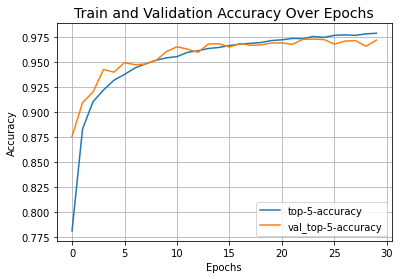

In [77]:
plt.plot(history.history["top-5-accuracy"], label="top-5-accuracy")
plt.plot(history.history["val_top-5-accuracy"], label="val_top-5-accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracy Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()
